<a href="https://colab.research.google.com/github/majdkhalife/StockPredictor/blob/main/GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and setup env

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install arch
import arch
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 31.5 MB/s eta 0:00:00


## Choose stock

In [2]:
stock_data = yf.download("OCGN", start = "2024-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
get_ticker = yf.Ticker("OCGN")

## Perform volatility check

In [72]:
get_stock_data = pd.DataFrame(stock_data)

In [73]:
get_stock_data = get_stock_data.reset_index()
get_stock_data = get_stock_data[['Date', 'Close', 'Open']]

In [74]:
get_stock_data.head()

Price,Date,Close,Open
Ticker,,OCGN,OCGN
0,2024-01-02,0.658,0.586
1,2024-01-03,0.653,0.716
2,2024-01-04,0.653,0.650
3,2024-01-05,0.669,0.675
4,2024-01-08,0.650,0.678


In [75]:
get_stock_data['log_return'] = np.log(get_stock_data['Close'] / get_stock_data['Close'].shift(1))

In [76]:
get_stock_data.head()

Price,Date,Close,Open,log_return
Ticker,,OCGN,OCGN,
0,2024-01-02,0.658,0.586,NaN
1,2024-01-03,0.653,0.716,-0.007628
2,2024-01-04,0.653,0.650,0.000000
3,2024-01-05,0.669,0.675,0.024207
4,2024-01-08,0.650,0.678,-0.028812


In [77]:
get_stock_data = get_stock_data.dropna()

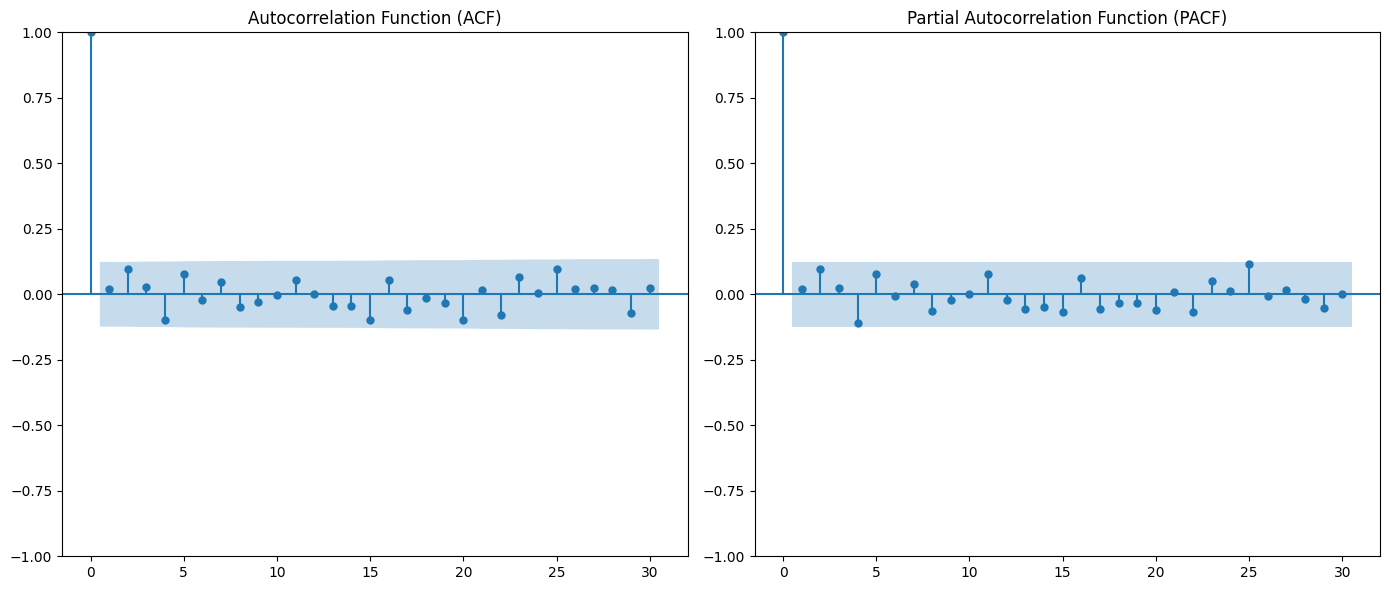

In [78]:
# Plot the ACF and PACF for log returns
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(get_stock_data['log_return'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(get_stock_data['log_return'].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [79]:
# Calculate ACF and PACF values
acf_values = acf(get_stock_data['log_return'].dropna(), nlags=30)
pacf_values = pacf(get_stock_data['log_return'].dropna(), nlags=30)
# Find significant lags for ACF (q)
significant_acf_lags = [lag for lag, value in enumerate(acf_values) if abs(value) > 1.96 / np.sqrt(len(get_stock_data['log_return'].dropna()))]

# Find significant lags for PACF (p)
significant_pacf_lags = [lag for lag, value in enumerate(pacf_values) if abs(value) > 1.96 / np.sqrt(len(get_stock_data['log_return'].dropna()))]

# Exclude lag 0 (since it's always 1 and not relevant for AR/MA orders)
significant_acf_lags = [lag for lag in significant_acf_lags if lag != 0]
significant_pacf_lags = [lag for lag in significant_pacf_lags if lag != 0]

# Determine max p and q
max_p = max(significant_pacf_lags) if significant_pacf_lags else 0
max_q = max(significant_acf_lags) if significant_acf_lags else 0

print(f"Max p (PACF): {max_p}")
print(f"Max q (ACF): {max_q}")

Max p (PACF): 25
Max q (ACF): 0


In [80]:
get_stock_data = get_stock_data.replace([np.inf, -np.inf], np.nan).dropna()

# Define function for model evaluation
def evaluate_model(data):
    # Fit GARCH model
    am = arch_model(get_stock_data['log_return'], mean='Zero', vol='Garch', p=25, q=0, rescale=True)
    res = am.fit(disp='off')

    # Calculate AIC and BIC
    aic = res.aic
    bic = res.bic

    # Perform backtesting
    residuals = get_stock_data['log_return'] - res.conditional_volatility
    res_t = residuals / res.conditional_volatility
    backtest = (res_t**2).sum()

    # Out-of-sample testing
    data_length = len(get_stock_data)
    train_size = int(0.8 * data_length)
    train_data = get_stock_data[:train_size]
    test_data = get_stock_data[train_size:]

    res_oos = am.fit(last_obs=train_data.index[-1], disp='off')
    forecast = res_oos.forecast(start=train_data.index[-1], horizon=len(test_data))

    # Calculate out-of-sample forecast error
    forecast_vol = forecast.residual_variance.iloc[-1, :]
    error = (test_data['log_return'] - forecast_vol).dropna()

    return aic, bic, backtest, error

# Evaluate the GARCH model using log returns data
aic, bic, backtest, forecast_error = evaluate_model(get_stock_data)

# Print the evaluation results
print(f'AIC: {aic}')
print(f'BIC: {bic}')
print(f'Backtesting Result: {backtest}')

AIC: 463.11293110120243
BIC: 554.7747075186288
Backtesting Result: 254.66375957738123


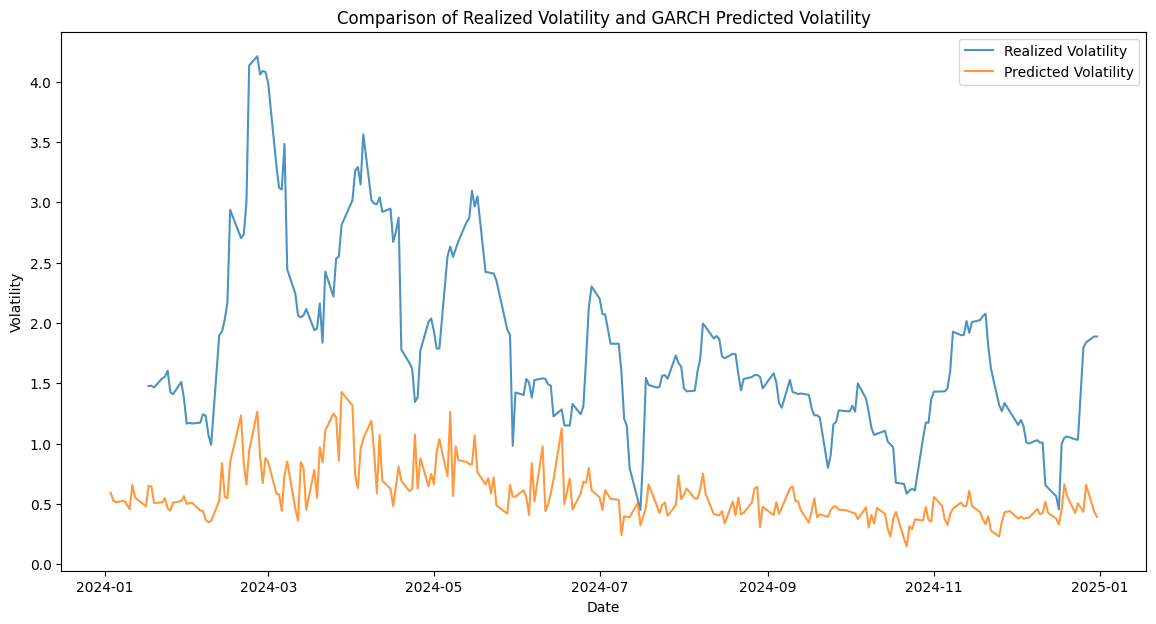

Correlation between realized and predicted volatility: 0.63


In [81]:
# Calculate realized volatility
# Realized volatility is the square root of the sum of squared log returns over a rolling window
realized_volatility = get_stock_data['log_return'].rolling(window=10).std() * np.sqrt(1000)

am = arch_model(get_stock_data['log_return'], mean='Zero', vol='Garch', p=30, q=14, rescale=True)
res = am.fit(disp='off')  # Store the fitted results
# Predicted volatility (conditional volatility) from the GARCH model
predicted_volatility = res.conditional_volatility

# Align indices (optional if you're plotting both)
get_stock_data['realized_volatility'] = realized_volatility
get_stock_data['predicted_volatility'] = predicted_volatility

# Plot realized volatility vs. predicted volatility
plt.figure(figsize=(14, 7))
plt.plot(get_stock_data['Date'], get_stock_data['realized_volatility'], label='Realized Volatility', alpha=0.8)
plt.plot(get_stock_data['Date'], get_stock_data['predicted_volatility'], label='Predicted Volatility', alpha=0.8)
plt.title('Comparison of Realized Volatility and GARCH Predicted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Evaluate accuracy using correlation
correlation = get_stock_data[['realized_volatility', 'predicted_volatility']].dropna().corr().iloc[0, 1]
print(f"Correlation between realized and predicted volatility: {correlation:.2f}")


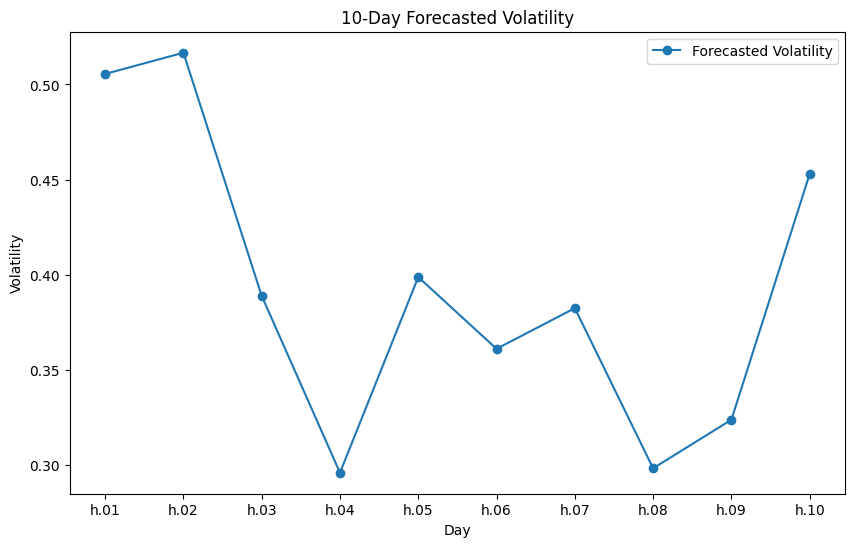

In [82]:
forecast_horizon = 10
forecasts = res.forecast(horizon=forecast_horizon)
forecast_vol = np.sqrt(forecasts.variance.iloc[-1, :])

plt.figure(figsize=(10, 6))
plt.plot(forecast_vol, marker='o', label='Forecasted Volatility')
plt.title(f'{forecast_horizon}-Day Forecasted Volatility')
plt.xlabel('Day')
plt.ylabel('Volatility')
plt.legend()
plt.show()